In [1]:
import numpy as np
import pandas as pd  
import random as rnd
import math
from tqdm import tqdm_notebook
from sklearn.metrics import make_scorer, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, NearestCentroid
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from IPython.display import display, HTML
from utils import mae_score, NPR
from joblib import Parallel, delayed

%matplotlib inline
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def mae_score(y_pred, y): 
#     if norm:
#         y_ = y / np.linalg.norm(y, axis=1, ord=1)[:,None]
    return (np.linalg.norm(y_pred - y, axis=1, ord=1)/ (np.linalg.norm(y, axis=1, ord=1) + 1e-10)).mean()

In [4]:
scorer_mae = make_scorer(mae_score, greater_is_better=False)
# knn = KNeighborsRegressor(n_neighbors=5, leaf_size=30, p=2, weights='distance')
knn=LGBMRegressor(n_estimators=500, reg_alpha=0.1, reg_lambda=0.1, learning_rate=0.01)
mo_knn = MultiOutputRegressor(knn)

In [8]:
for dataset_name in ['ptb']:
    for tax_name in ['f']:
#         for mf_method_name in ['lle', 'isomap']: # , 'ae'

            dataframe = pd.read_csv(f'{dataset_name}/pivot_{tax_name}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
            dataframe = dataframe.drop('Unnamed: 0', axis = 1).values
            data = np.genfromtxt(f"./separate_datasets_proj/{dataset_name}_proj_{tax_name.lower()}.csv", delimiter=';')

#             if mf_method_name == 'ae':
#                 data_trans = np.load(f"./separate_datasets_transformed/{dataset_name}_proj_{tax_name.lower()}_{mf_method_name}.npy") # , delimiter=';'
#             else:
#                 data_trans = np.genfromtxt(f"./separate_datasets_transformed/{dataset_name}_proj_{tax_name.lower()}_{mf_method_name}.csv", delimiter=';')
            
            cv = -cross_val_score(mo_knn, data, dataframe, scoring=scorer_mae, cv=5)
            print(dataset_name, tax_name, cv.mean(), cv.std())

# transformer = Isomap(n_components=n)
# dataset_transformed = transformer.fit_transform(data_AGP_g)
# errs_AGP_g.append(-cross_val_score(mo_knn, dataset_transformed, data_AGP_g, scoring=scorer_mae, cv=5, n_jobs=-1).mean())

In [60]:
# param_grid = {'estimator__max_depth':[5,10,-1], 
#               'estimator__reg_alpha':[1e-1,1e-2,1e-3],
#               'estimator__reg_lambda':[1e-1,1e-2,1e-3]}
# gs = GridSearchCV(mo_knn, param_grid, scoring=scorer_mae, cv=3, n_jobs=-1, verbose=1)
# gs.fit(data_trans, dataframe)

In [48]:
# npr_k_range = np.arange(10,4000,200)
# nprs = Parallel(n_jobs=-1)(delayed(NPR)(data,data_trans,k) for k in tqdm_notebook(npr_k_range))
# plt.plot(nprs)

# Errors

In [18]:
errs = {'AGP_O': {'AutoEncoder':0.124, 'Isomap':0.124, 'LLE':0.13},
       'HMP_O': {'AutoEncoder':0.16, 'Isomap':0.28, 'LLE':0.3}}
#         'AGP_F': {'AutoEncoder':0.2, 'Isomap':0.28, 'LLE':0.28},
#        'HMP_F': {'AutoEncoder':0.16, 'Isomap':0.3, 'LLE':0.53},
#        'AGP_G': {'AutoEncoder':0.25, 'Isomap':0.32, 'LLE':0.33},
#        'HMP_G': {'AutoEncoder':0.16, 'Isomap':0.3, 'LLE':0.48}}

In [19]:
errs_dict

,"Dataset: AGP, Tax: O","Dataset: HMP, Tax: O"
AutoEncoder,0.15,0.16
Isomap,0.12,0.30
LLE,0.13,0.35


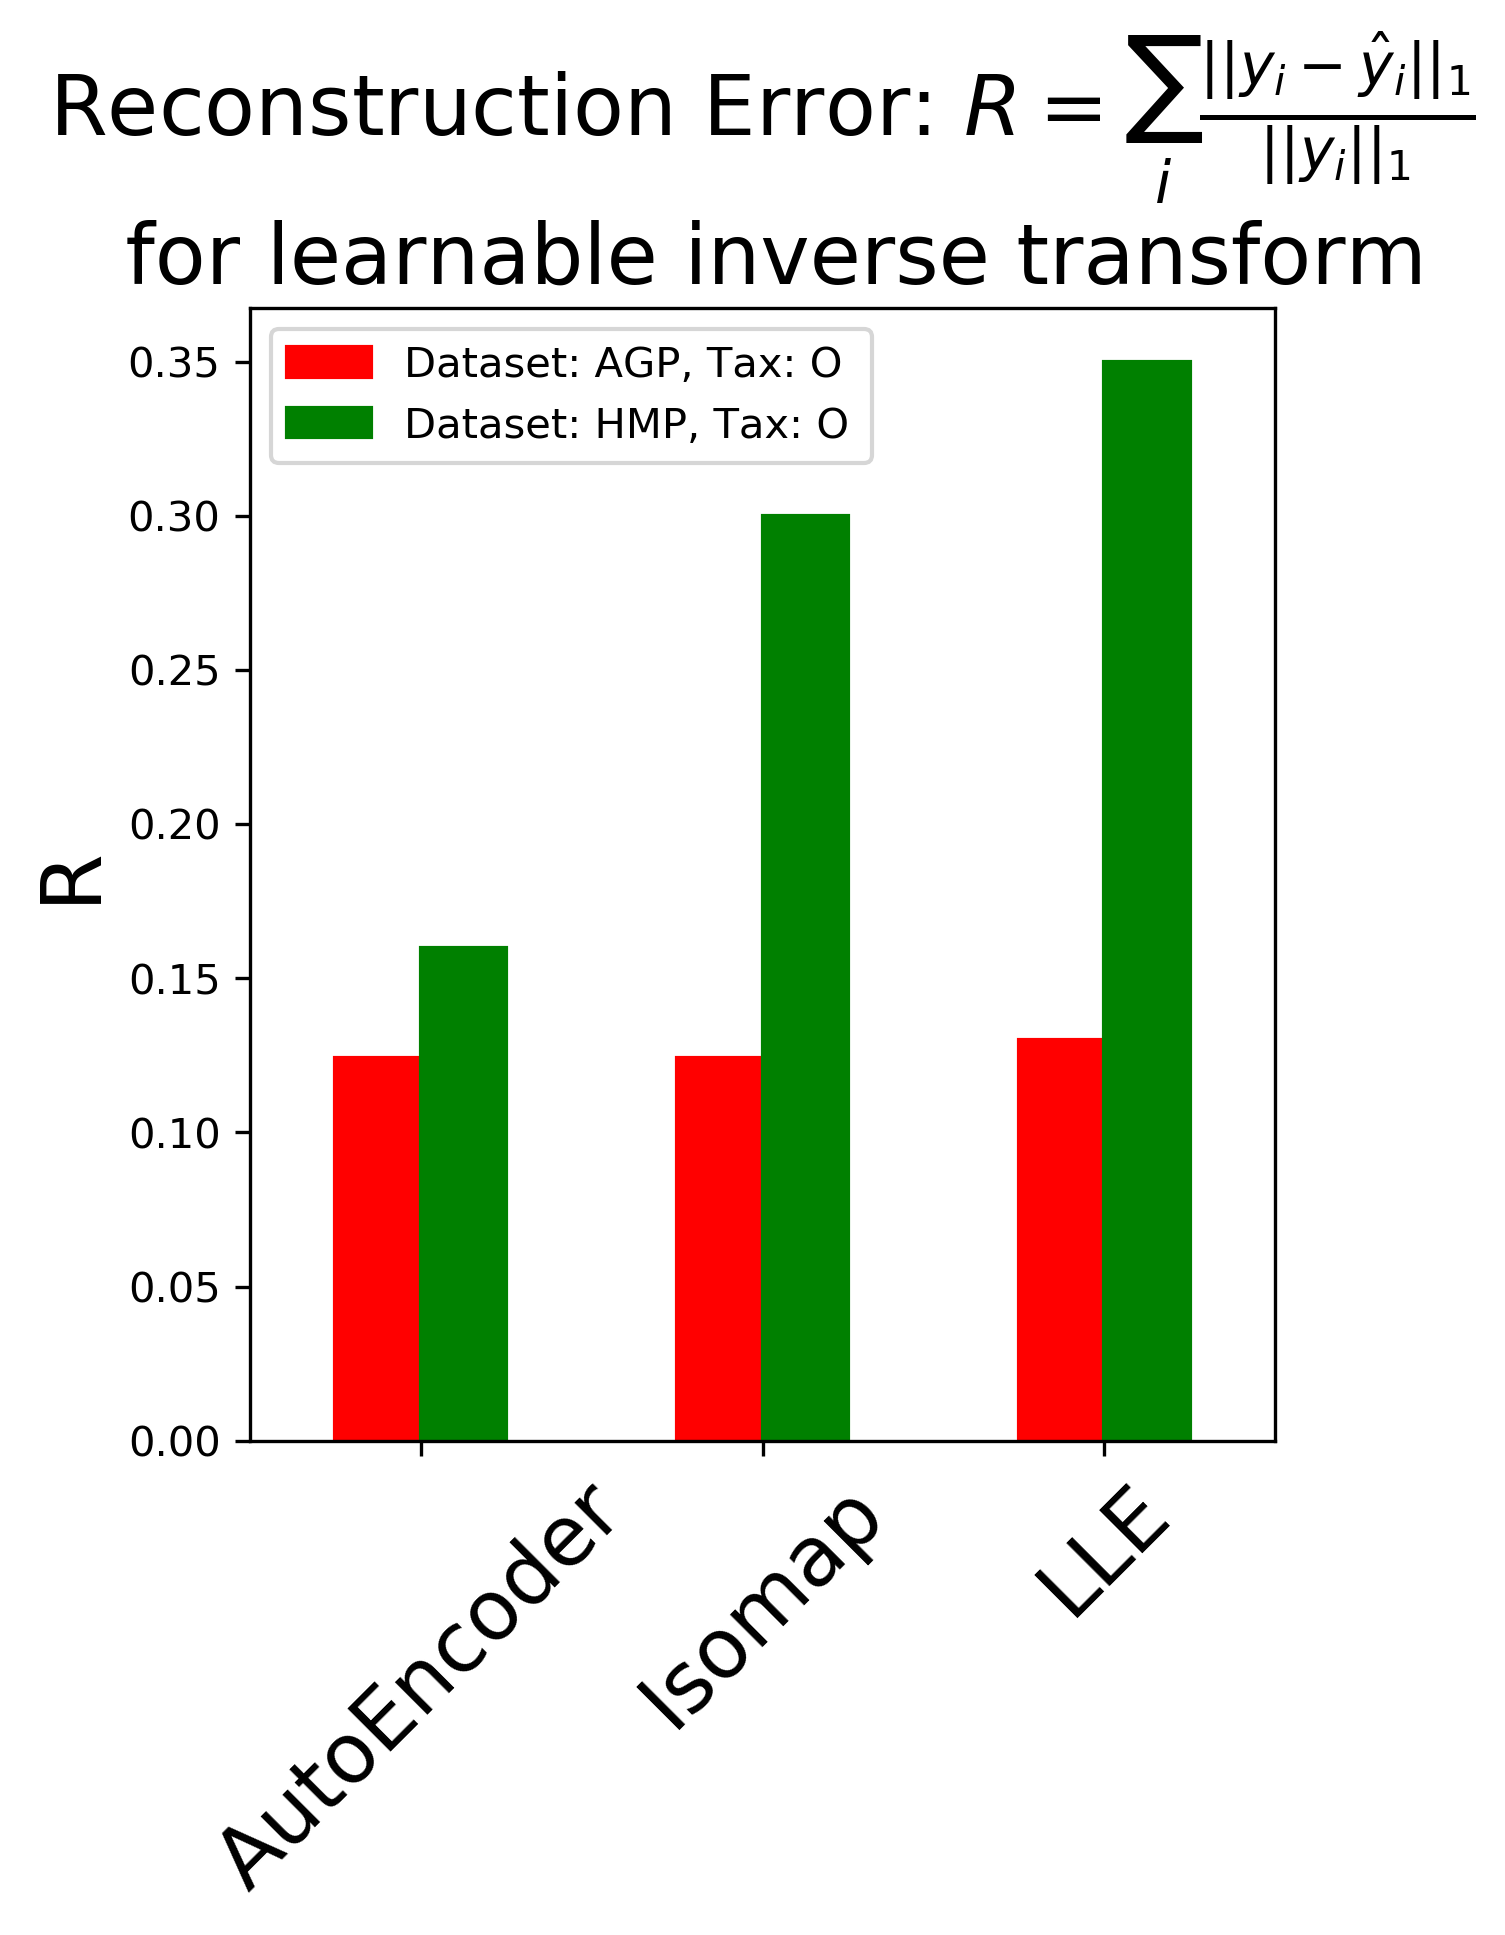

In [20]:
fig = plt.figure(figsize=(15,5), dpi=300)
for k, tax in enumerate(['O']):
    ax = fig.add_subplot(1, 3, k+1) # , projection='3d'

    errs_dict = pd.DataFrame({f'Dataset: AGP, Tax: {tax} ': errs[f'AGP_{tax}'],
                              f'Dataset: HMP, Tax: {tax}': errs[f'HMP_{tax}']})

    barlist = errs_dict.plot.bar(ax=ax)
    barlist.get_children()[0].set_color('red')
    barlist.get_children()[1].set_color('red')
    barlist.get_children()[2].set_color('red')
    barlist.get_children()[3].set_color('green')
    barlist.get_children()[4].set_color('green')
    barlist.get_children()[5].set_color('green')

    barlist.get_children()[-2].get_children()[0].get_children()[-1].get_children()[0].get_children()[0].get_children()[0].get_children()[0].set_color('red')
    barlist.get_children()[-2].get_children()[0].get_children()[-1].get_children()[0].get_children()[1].get_children()[0].get_children()[0].set_color('green')

    plt.ylabel('R', fontsize=20) # \underset{i}{\sum} 
    plt.title(r'Reconstruction Error: $R = \sum_{i} \frac{||y_i - \hat{y}_i||_1}{||y_i||_1}$' + '\n for learnable inverse transform', fontsize=20)
#     plt.title(r'Reconstruction Error: $R$', fontsize=20)
    plt.xticks(rotation=45, fontsize=20)
plt.show()
